In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
from torchvision.datasets import EuroSAT
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

train_dataset = EuroSAT(root="./data", transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

100%|██████████| 94.3M/94.3M [00:00<00:00, 293MB/s]


In [ ]:
import timm
import torch.nn as nn

# Swapping classifier head to match 10 EuroSAT classes
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss:.4f} | Accuracy: {acc:.2f}%")


  0%|          | 0/844 [00:00<?, ?it/s]

Epoch [1/5] Loss: 187.7664 | Accuracy: 92.62%


  0%|          | 0/844 [00:00<?, ?it/s]

Epoch [2/5] Loss: 89.9605 | Accuracy: 96.65%


  0%|          | 0/844 [00:00<?, ?it/s]

Epoch [3/5] Loss: 70.7499 | Accuracy: 97.25%


  0%|          | 0/844 [00:00<?, ?it/s]

Epoch [4/5] Loss: 56.9810 | Accuracy: 97.79%


  0%|          | 0/844 [00:00<?, ?it/s]

Epoch [5/5] Loss: 51.4056 | Accuracy: 97.96%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


                      precision    recall  f1-score   support

          AnnualCrop       1.00      0.96      0.98      3000
              Forest       1.00      0.98      0.99      3000
HerbaceousVegetation       0.97      0.99      0.98      3000
             Highway       0.95      1.00      0.97      2500
          Industrial       0.99      0.97      0.98      2500
             Pasture       0.96      0.99      0.98      2000
       PermanentCrop       0.96      0.99      0.97      2500
         Residential       1.00      0.98      0.99      3000
               River       1.00      0.99      0.99      2500
             SeaLake       0.99      1.00      0.99      3000

            accuracy                           0.98     27000
           macro avg       0.98      0.98      0.98     27000
        weighted avg       0.98      0.98      0.98     27000



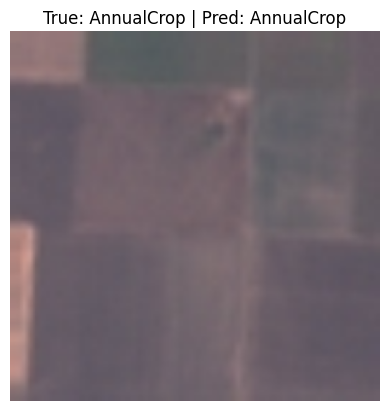

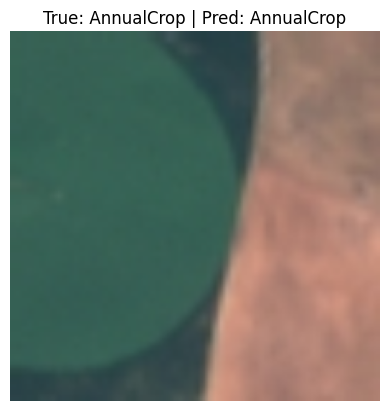

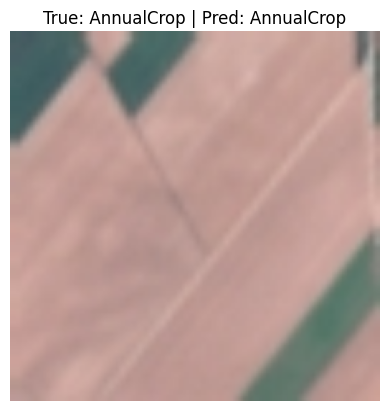

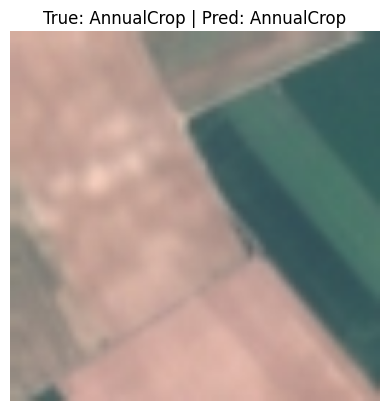

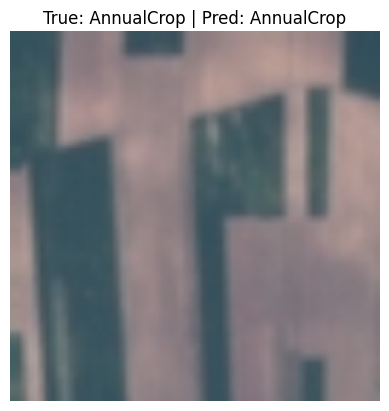

In [ ]:
import matplotlib.pyplot as plt

def imshow(img, label, pred):
    img = img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + \
          torch.tensor([0.485, 0.456, 0.406])
    img = img.numpy().clip(0, 1)
    plt.imshow(img)
    plt.title(f"True: {label} | Pred: {pred}")
    plt.axis('off')
    plt.show()

# Show few predictions
for i in range(5):
    img, label = train_dataset[i]
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    imshow(img, train_dataset.classes[label], train_dataset.classes[pred])
